# **Chapter 10**
## *Building Univariate Time Series Models Using Statistical Methods*, 

This chapter kick offs the journey into modeling and forecasting time series. The chapter intuitively explains what autocorrelation function (ACF) and partial autocorrelation function (PACF) plots are and how they are used, and then moves in to training, diagnosing, and comparing different models, including exponential smoothing, autoregressive integrated moving average (ARIMA), and seasonal ARIMA (SARIMA). Additionally, this chapter introduces grid search and hyperparameter tuning.

In this chapter, we will cover the following recipes:
* Plotting ACF and PACF
* Forecasting univariate time series data with exponential smoothing
* Forecasting univariate time series data with non-seasonal ARIMA
* Forecasting univariate time series data with seasonal ARIMA

Before diving into these recipes, pay special attention to the upcoming Technical requirements section, in which you will perform upfront preparation. This will remove any distractions and repetitive coding so that you can focus on the recipe's core goals and the concepts behind each implementation.

# ---START: Technical Requirements---


In [1]:
import statsmodels
statsmodels.__version__

'0.14.2'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm

warnings.filterwarnings('ignore')

In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
import matplotlib 
import scipy 
import sklearn

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
sklearn -> {sklearn.__version__}
''')


Matplotlib -> 3.9.2
pandas -> 2.2.2   
numpy -> 1.26.4
scipy -> 1.13.1
statsmodels -> 0.14.2
sklearn -> 1.6.1



In [5]:
life_file = ('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/refs/heads/main/datasets/Ch10/life_expectancy_birth.csv')
milk_file = ('https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/refs/heads/main/datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [6]:
life.shape

(59, 1)

In [7]:
milk.shape

(168, 1)

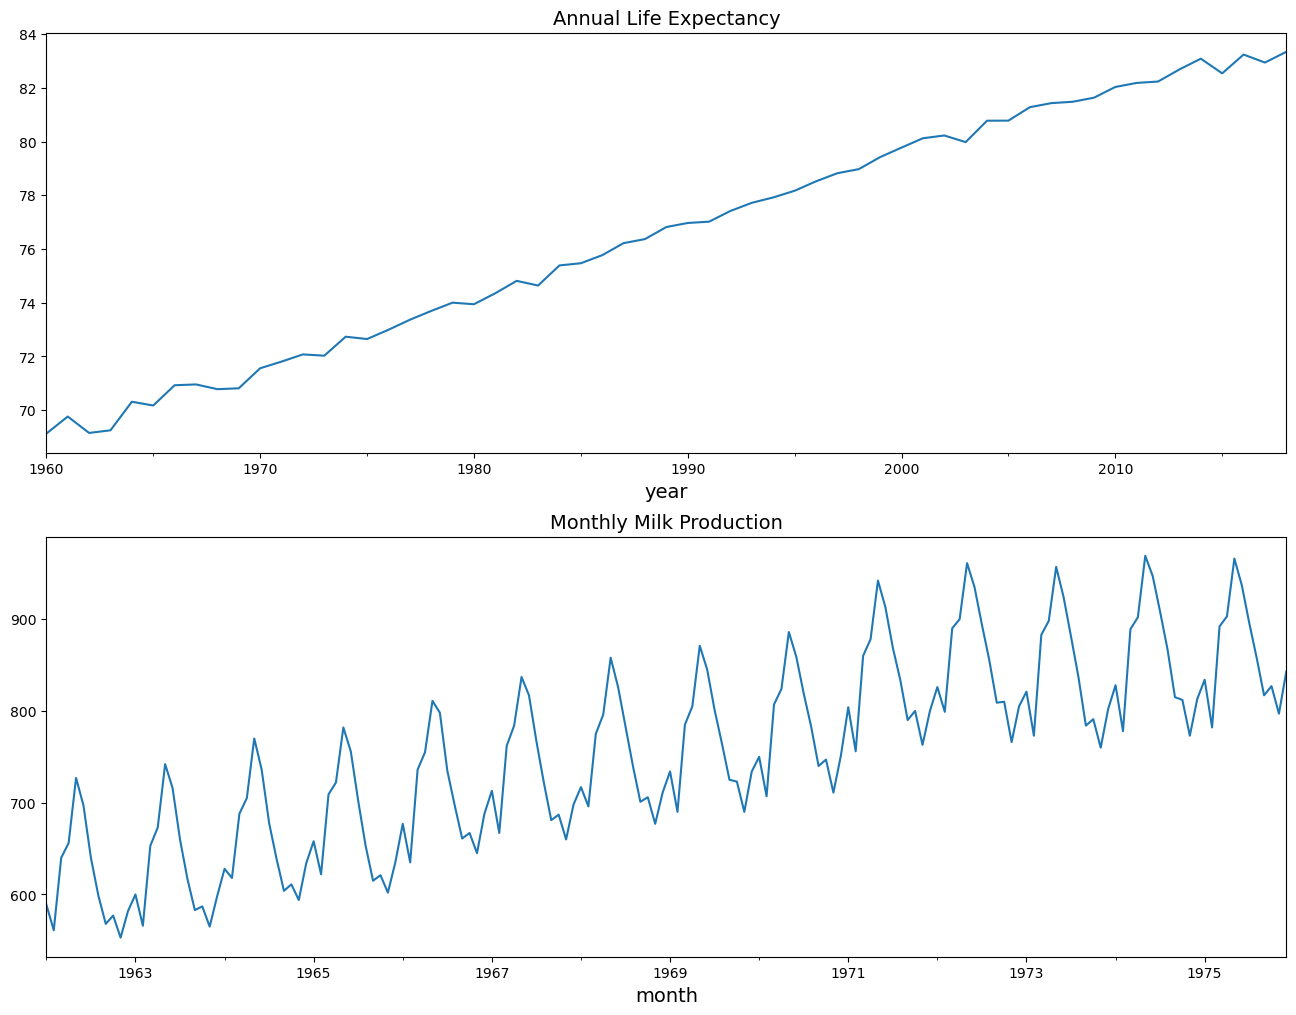

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

life.plot(title='Annual Life Expectancy', 
                        legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', 
                        legend=False, ax=ax[1]);

# plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [9]:
def split_data(data, test_split):
    
    l = len(data)                                     # Get the total length of the dataset
    t_idx = round(l * (1 - test_split))               # Compute the index for splitting
    train, test = data[:t_idx], data[t_idx:]          # Split data into train and test sets
    print(f'train: {len(train)} , test: {len(test)}') # Print the sizes of the splits
    
    return train, test                                # Return the train and test sets

In [10]:
test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [11]:
def check_stationarity(df):
    
    results = adfuller(df)[1:3]  # Extract p-value and number of lags from ADF test
    s = 'Non-Stationary'         # Default assumption: non-stationary data
    if results[0] < 0.05:        # Check if p-value is less than significance level (0.05)
        s = 'Stationary'         # If p-value < 0.05, reject null hypothesis -> data is stationary
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}") # Display results
    
    return (s, results[0])       # Return stationarity status and p-value

In [12]:
def get_best_model(score, c='AIC'):
    
    initial_score = score[0][c]        # Initialize with the first model's score
    best_model = 0                     # Track the index of the best model
    for k, v in score.items():         # Iterate over the models
        if v[c] < initial_score:       # Check if the current model has a lower score
            initial_score = v[c]       # Update the lowest score
            best_model = k             # Update the best model index
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')  # Display best model
    
    return score[best_model]['model']  # Return the best model

In [13]:
def plot_forecast(model, start, train, test):
    
    # Generate forecasted values for the test set
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)  
    
    ax = train.loc[start:].plot(style='--')  # Plot training data with dashed lines
    test.plot(ax=ax)                         # Plot test data
    forecast.plot(ax=ax, style='-.')         # Plot forecasted data with dash-dot lines
    ax.legend(['orig_train', 'orig_test', 'forecast'])  # Add legend for clarity
    
    # plt.show()                             # Optional: Uncomment to display the plot immediately
    return ax                                # Return the axis object for further customization

In [14]:
def combinator(items, r=1):
    
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    
    return combo                                    # Return the list of combinations

# Recipe 1. Plotting ACF and PACF

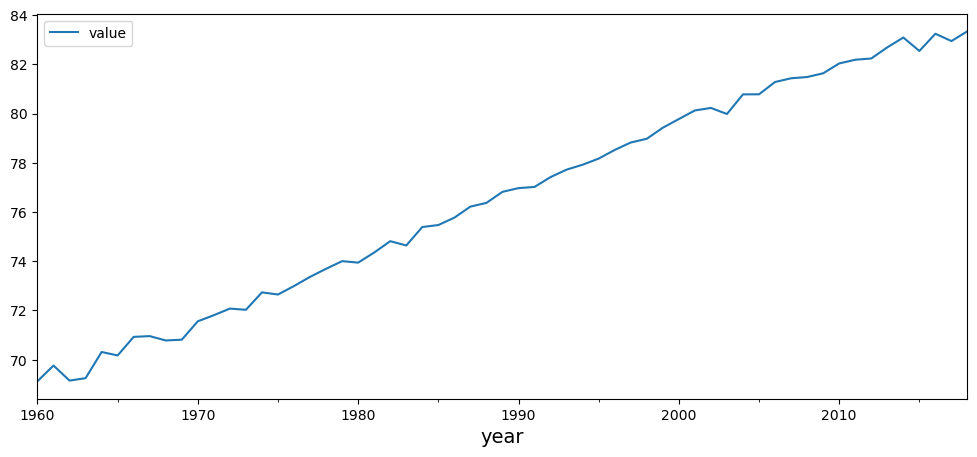

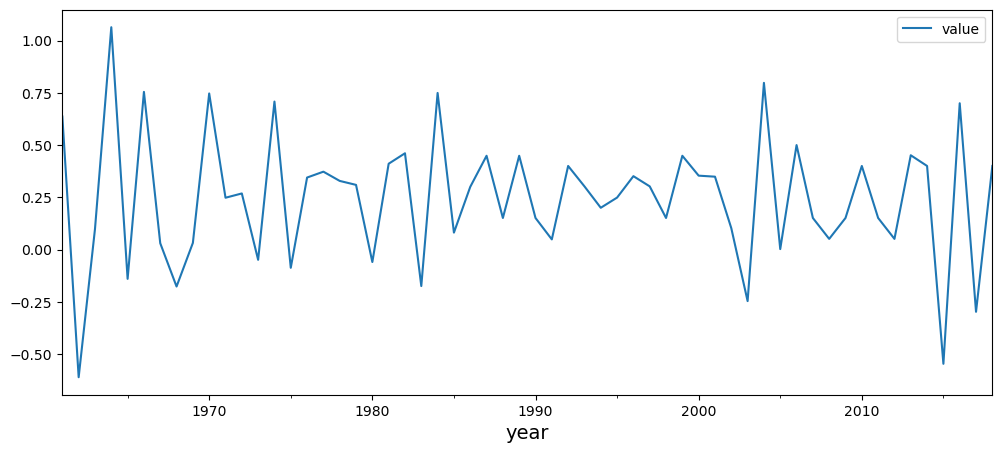

In [15]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot();
life_diff = life.diff().dropna()
life_diff.plot();

In [16]:
check_stationarity(life_diff);

'Stationary	 p-value:1.556218967600307e-14 	 lags:1


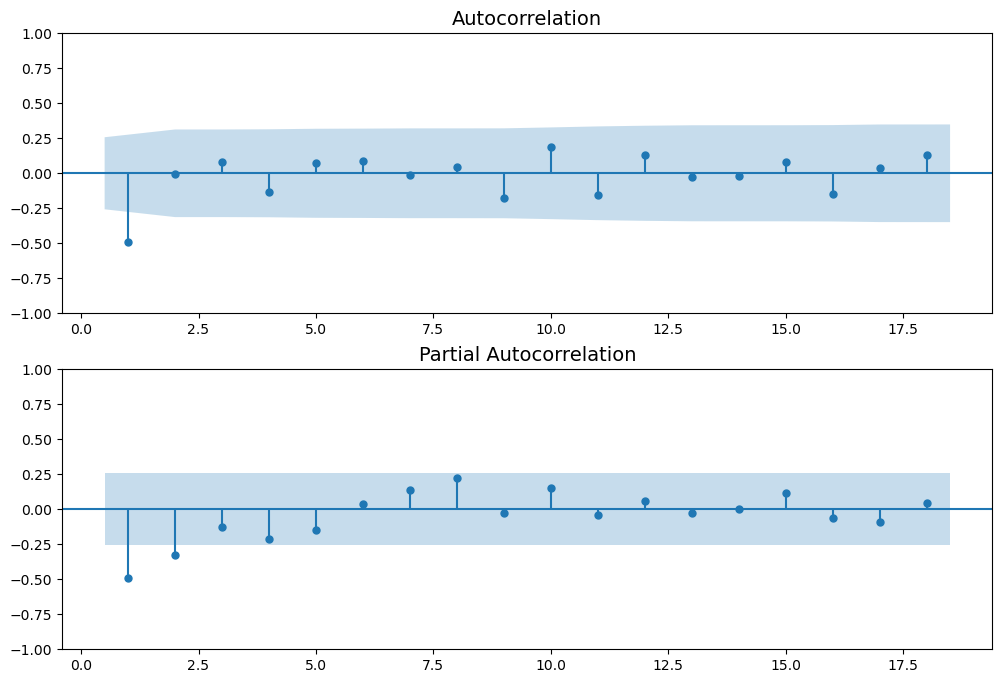

In [17]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show()

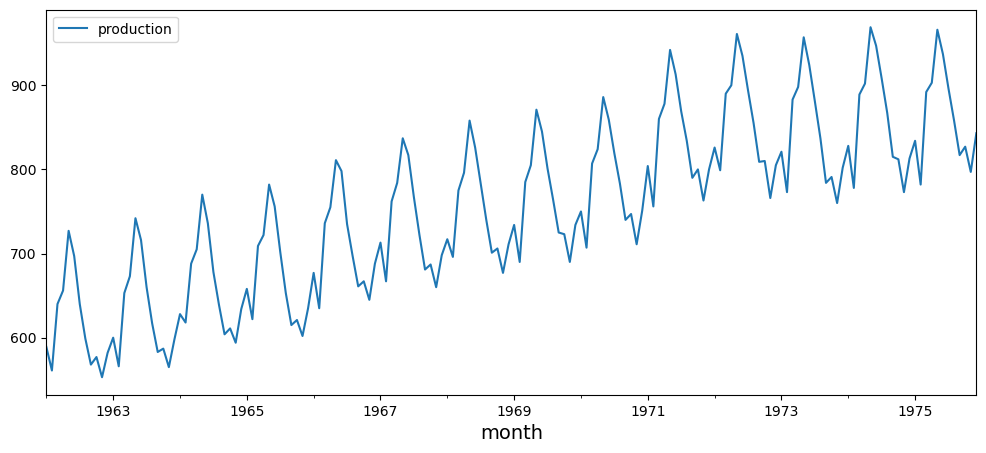

In [18]:
milk.plot();

In [19]:
# Compute the 12-month differenced series to remove seasonality
milk_diff_12 = milk.diff(12).dropna()

In [20]:
check_stationarity(milk_diff_12);

'Non-Stationary	 p-value:0.1607988052771142 	 lags:12


In [21]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna() #<====== !!!!!

check_stationarity(milk_diff_12_1);

'Stationary	 p-value:1.865423431878921e-05 	 lags:11


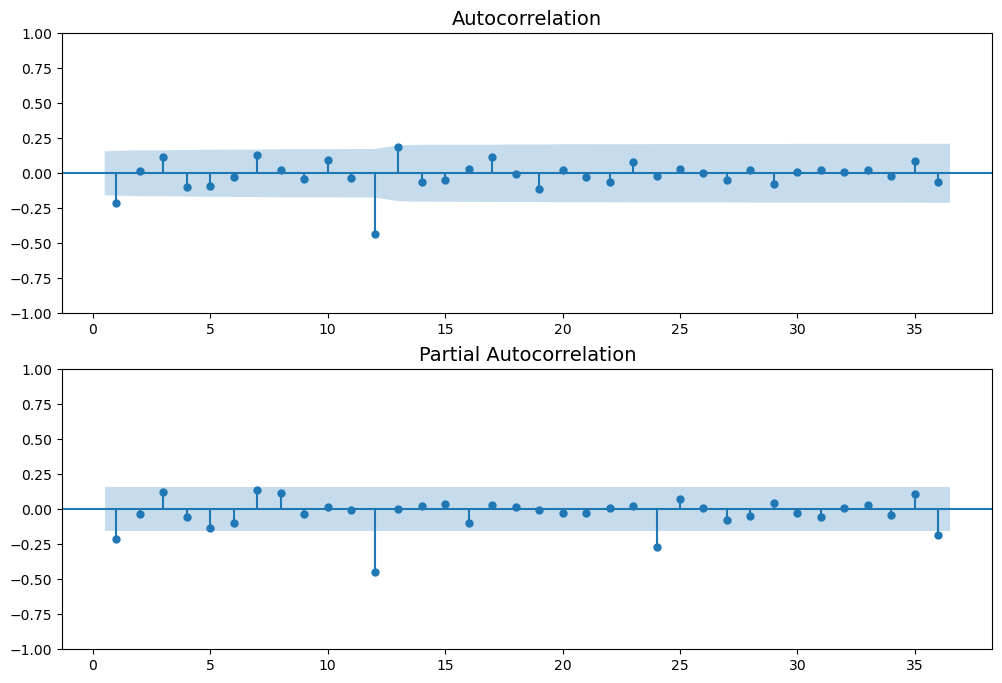

In [22]:
fig, ax = plt.subplots(2,1, figsize=(12,8))

plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)

plt.show()

## SARIMAX

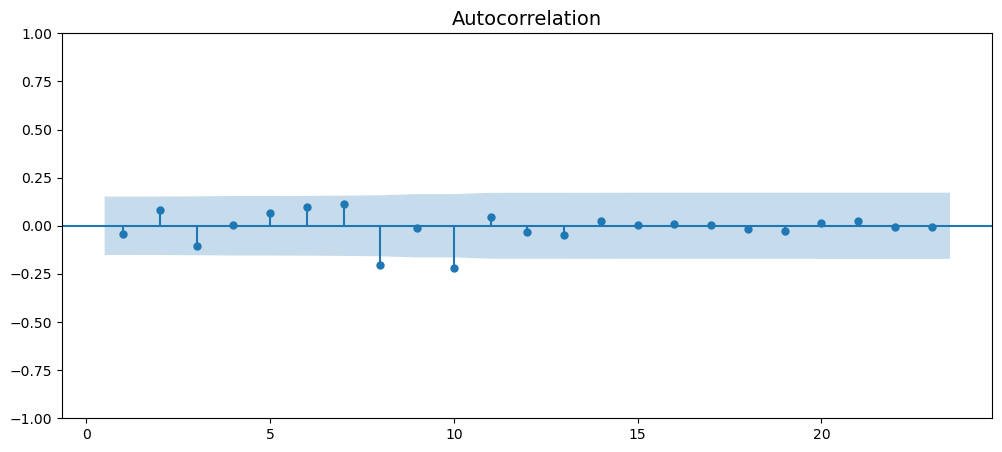

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)

plot_acf(model.resid[1:], zero=False)

plt.show()

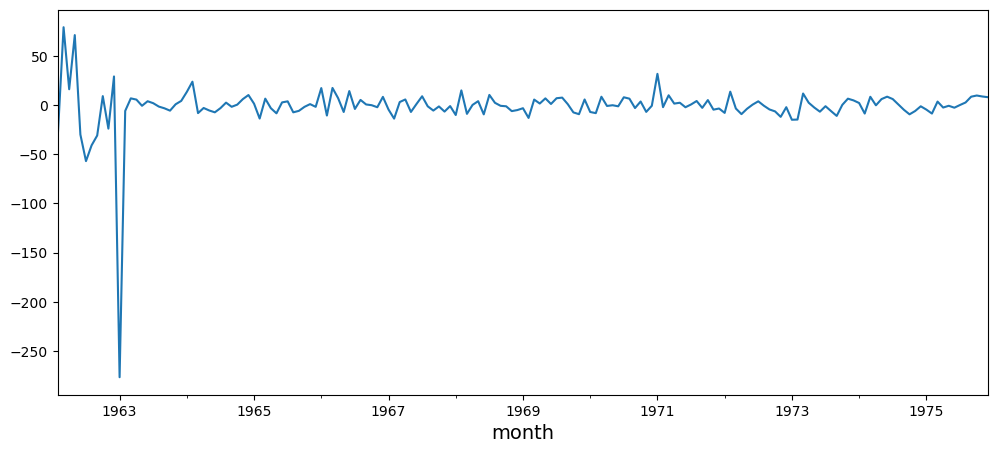

In [24]:
model.resid[1:].plot();

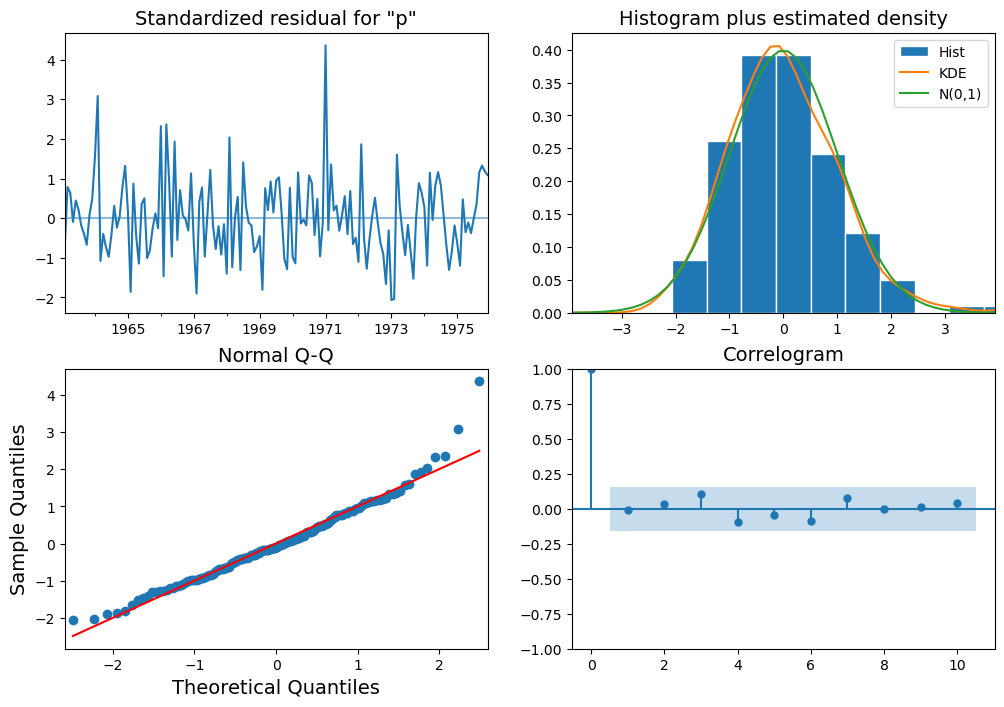

In [25]:
model.plot_diagnostics(figsize=(12, 8))
plt.show();

In [26]:
# Extract residuals from the model, excluding the first observation
model.resid[1:]  

month
1962-02-01   -27.995259
1962-03-01    78.999549
1962-04-01    16.001272
1962-05-01    71.000258
1962-06-01   -29.998857
                ...    
1975-08-01     2.556263
1975-09-01     8.435671
1975-10-01     9.640233
1975-11-01     8.624987
1975-12-01     7.918949
Length: 167, dtype: float64

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(model.resid, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.340295,0.559659
2,2.995650,0.223616
3,2.995795,0.392274
4,4.629365,0.327483
5,4.703891,0.453075
6,5.114835,0.529171
7,5.220309,0.633098
8,6.518364,0.589371
9,6.540064,0.684883
10,7.696060,0.658498


# Recipe 2. Forecasting Univariate Time Series Data with Exponential Smoothing

In [28]:
from statsmodels.tsa.api import ExponentialSmoothing

In [29]:
trend = ['add', 'mul']
damped = [True, False]

life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [30]:
# Flatten training and testing data into one-dimensional arrays
train = life_train.values.ravel()  # Convert training data to a 1D array
y = life_test.values.ravel()       # Convert testing data to a 1D array

score = {}  # Initialize an empty dictionary to store model evaluation metrics

# Iterate over each combination of trend and damped trend in life_ex_comb
for i, (t, dp) in enumerate(life_ex_comb):
    
    # Initialize the Exponential Smoothing model with specified parameters
    exp = ExponentialSmoothing(train, 
                               trend=t,         # Set the trend component
                               damped_trend=dp, # Apply damping if applicable
                               seasonal=None)   # No seasonal component
    
    # Fit the model using brute force optimization
    model = exp.fit(use_brute=True, optimized=True)   
    
    # Forecast the length of the test set
    y_hat = model.forecast(len(y))
    
    # Store evaluation metrics and model in the score dictionary
    score[i] = {'trend': t,               # Trend type used in the model
                'damped': dp,             # Whether damping was applied
                'AIC': model.aic,         # Akaike Information Criterion
                'BIC': model.bic,         # Bayesian Information Criterion
                'AICc': model.aicc,       # Corrected Akaike Information Criterion
                'RMSPE': rmspe(y, y_hat), # Root Mean Squared Percentage Error
                'RMSE': rmse(y, y_hat),   # Root Mean Squared Error
                'MAPE': mape(y, y_hat),   # Mean Absolute Percentage Error
                'model': model}           # Store the trained model

In [31]:
life_best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: -137.03060179498183


In [32]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Fri, 21 Mar 2025"
Box-Cox:,False,Time:,09:35:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621953,alpha,True
smoothing_trend,0.1621953,beta,True


In [33]:
life_best_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162195,True
smoothing_trend,beta,0.162195,True
initial_level,l.0,68.748480,True
initial_trend,b.0,0.242227,True


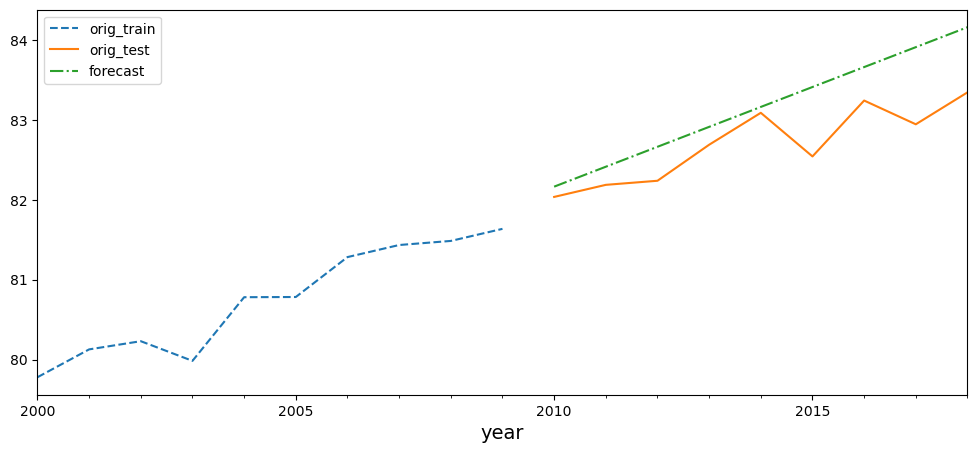

In [34]:
plot_forecast(life_best_model, '2000', life_train, life_test);

In [35]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]

milk_exp_comb = combinator([trend, damped, seasonal, periods])
milk_exp_comb

[('add', True, 'add', 4),
 ('add', True, 'add', 6),
 ('add', True, 'add', 12),
 ('add', True, 'mul', 4),
 ('add', True, 'mul', 6),
 ('add', True, 'mul', 12),
 ('add', False, 'add', 4),
 ('add', False, 'add', 6),
 ('add', False, 'add', 12),
 ('add', False, 'mul', 4),
 ('add', False, 'mul', 6),
 ('add', False, 'mul', 12),
 ('mul', True, 'add', 4),
 ('mul', True, 'add', 6),
 ('mul', True, 'add', 12),
 ('mul', True, 'mul', 4),
 ('mul', True, 'mul', 6),
 ('mul', True, 'mul', 12),
 ('mul', False, 'add', 4),
 ('mul', False, 'add', 6),
 ('mul', False, 'add', 12),
 ('mul', False, 'mul', 4),
 ('mul', False, 'mul', 6),
 ('mul', False, 'mul', 12)]

In [36]:
len(milk_exp_comb)

24

In [37]:
# Flatten training and testing data into one-dimensional arrays
train = milk_train.values.ravel()  # Convert training data to a 1D array
y = milk_test.values.ravel()       # Convert testing data to a 1D array

milk_model_scores = {}  # Initialize an empty dictionary to store model evaluation metrics

# Iterate over each combination of trend, damped trend, seasonality, and seasonal periods
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    
    # Initialize the Exponential Smoothing model with specified parameters
    exp = ExponentialSmoothing(train, 
                               trend=t,              # Set the trend component
                               damped_trend=dp,      # Apply damping if applicable
                               seasonal=s,           # Define seasonal component
                               seasonal_periods=sp)  # Set seasonal periodicity
    
    # Fit the model using brute force optimization
    model = exp.fit(use_brute=True, optimized=True)  
    
    # Forecast the length of the test set
    y_hat = model.forecast(len(y))
    
    # Store evaluation metrics and model in the dictionary
    milk_model_scores[i] = {'trend': t,                # Trend type used in the model
                            'damped': dp,              # Whether damping was applied
                            'AIC': model.aic,          # Akaike Information Criterion
                            'BIC': model.bic,          # Bayesian Information Criterion
                            'AICc': model.aicc,        # Corrected Akaike Information Criterion
                            'RMSPE': rmspe(y, y_hat),  # Root Mean Squared Percentage Error
                            'RMSE': rmse(y, y_hat),    # Root Mean Squared Error
                            'MAPE': mape(y, y_hat),    # Mean Absolute Percentage Error
                            'model': model}            # Store the trained model

In [38]:
milk_model = get_best_model(milk_model_scores)

Best model: 8 with lowest AIC score: 593.7138793829723


In [39]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Fri, 21 Mar 2025"
Box-Cox:,False,Time:,09:35:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859383,alpha,True
smoothing_trend,0.000000,beta,True


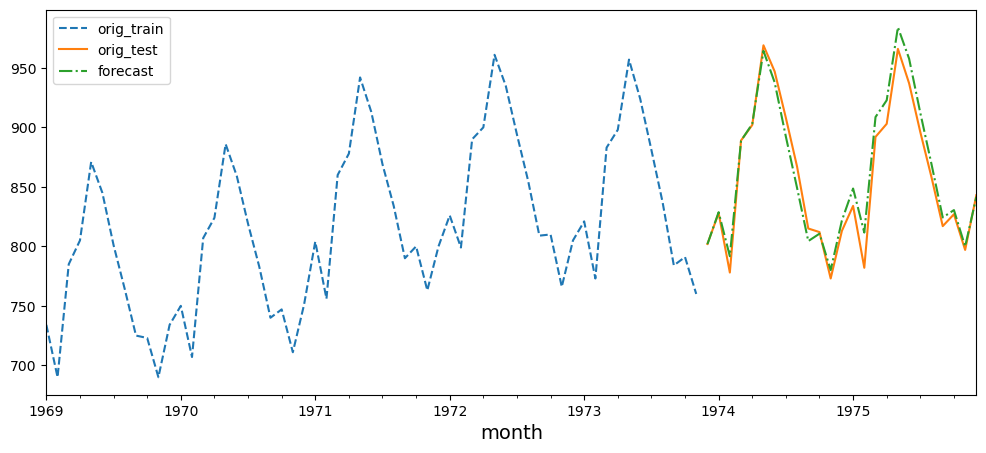

In [40]:
plot_forecast(milk_model, '1969', milk_train, milk_test);

## Exponential Smoothing

In [41]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

In [42]:
model = ExponentialSmoothing(seasonal_periods=12)        # Defines the exponential smoothing model with a seasonality of 12 periods

ts = TimeSeries.from_dataframe(milk.reset_index(),       # Converts the DataFrame into a TimeSeries object from Darts
                               time_col='month',         # Sets the time column as 'month'
                               value_cols='production',  # Sets the value column as 'production'
                               freq='MS')                # Sets the frequency to monthly ('MS' = Start of the month)

train, test = split_data(ts, 0.15)                       # Splits the data into training and testing sets, using 15% for testing

train: 143 , test: 25


In [43]:
# Trains the exponential smoothing model using the training data
model.fit(train)  

# Generates predictions for the test set length with 100 sample simulations
forecast = model.predict(len(test), num_samples=100)  

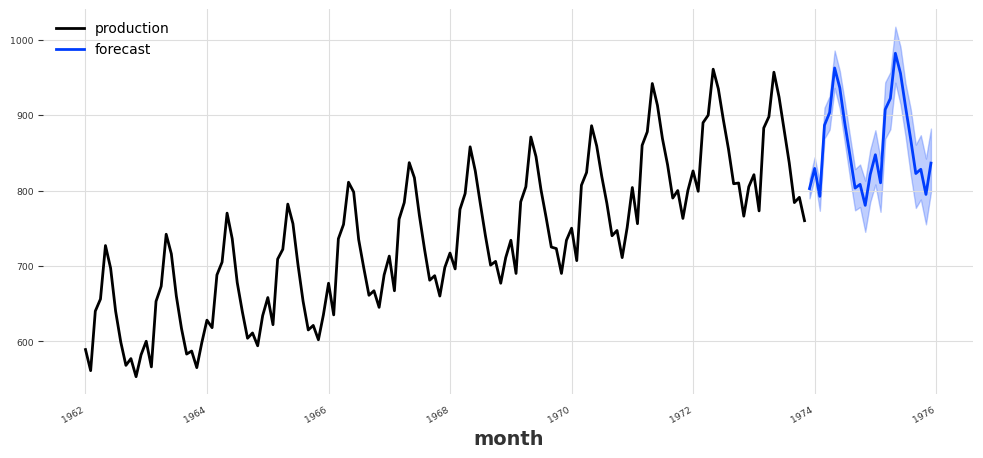

In [44]:
# Plots the training data
train.plot()  

# Plots the forecast with 5th and 95th percentiles (Darts Package)
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95);  

# Recipe 3. Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]  

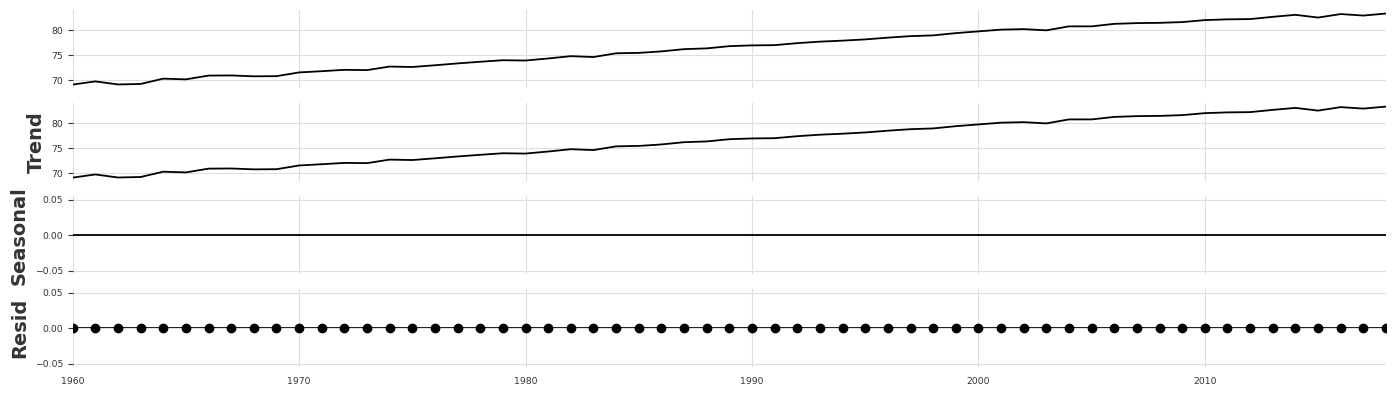

In [46]:
decomposed = seasonal_decompose(life)
decomposed.plot()
plt.show()

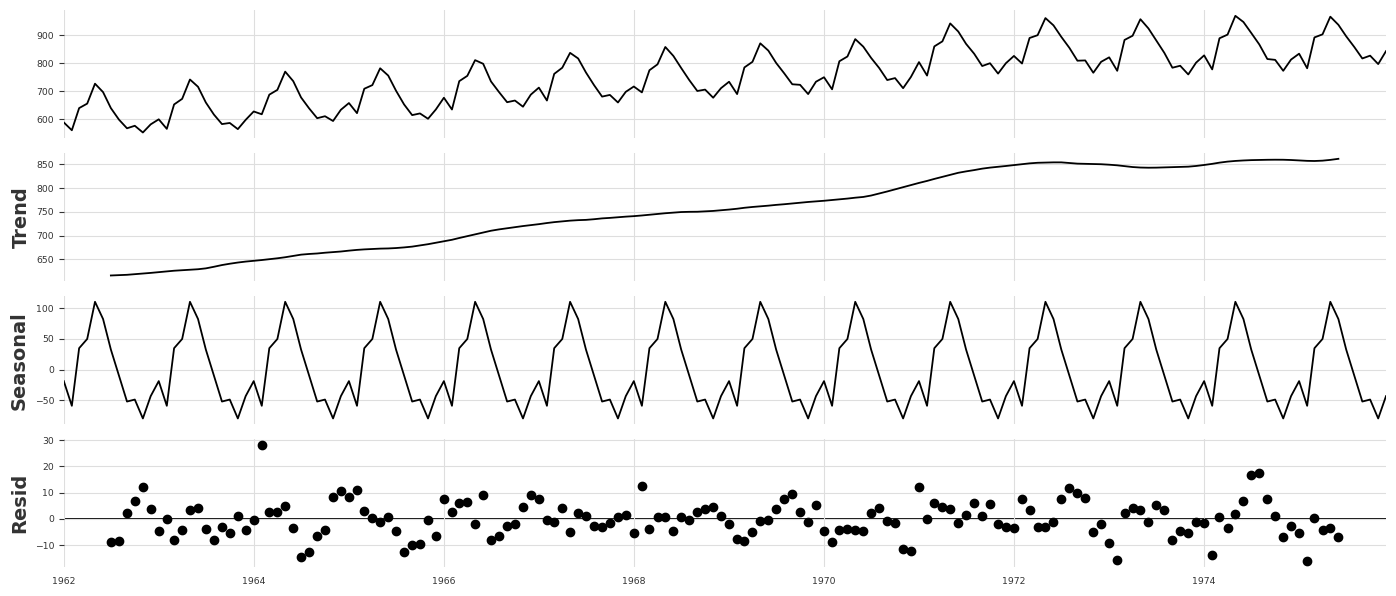

In [47]:
plt.rcParams["figure.figsize"] = [14, 6]  
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot(); plt.show()

In [48]:
from pandas.plotting import autocorrelation_plot

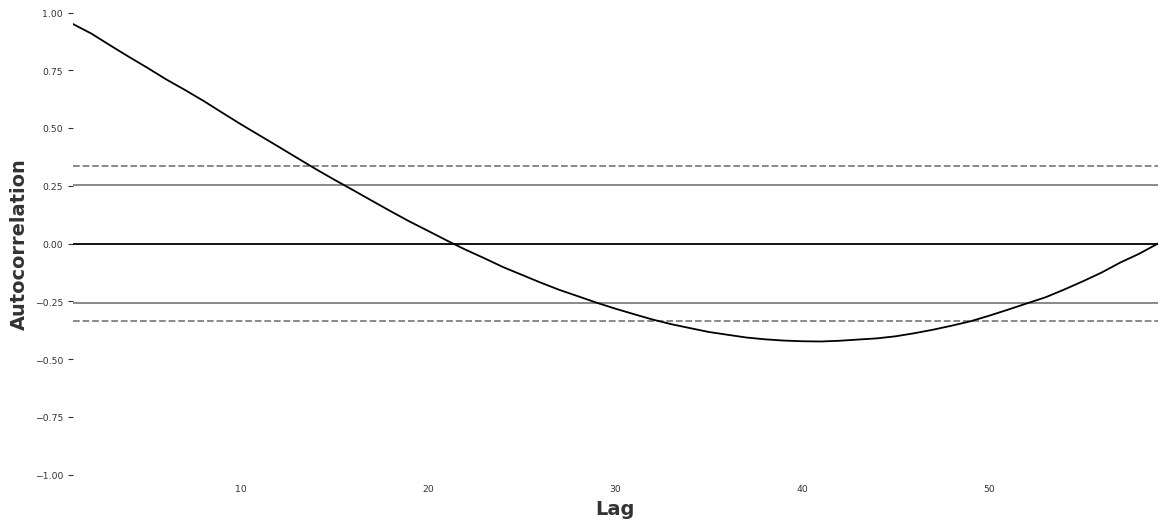

In [49]:
autocorrelation_plot(life);

In [50]:
check_stationarity(life);

'Non-Stationary	 p-value:0.6420882853800043 	 lags:2


In [51]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1);

'Stationary	 p-value:1.556218967600307e-14 	 lags:1


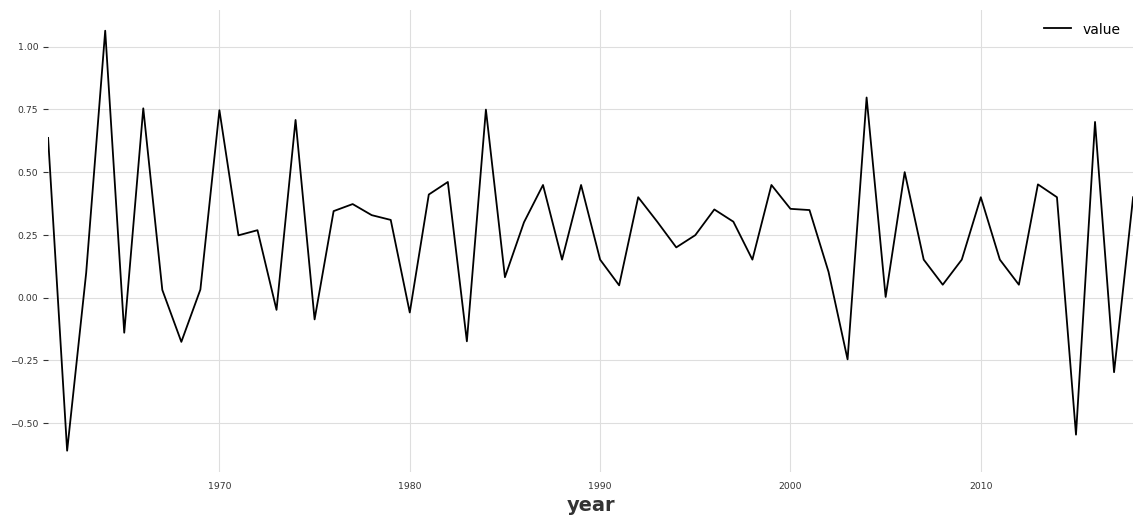

In [52]:
life_df1.plot();

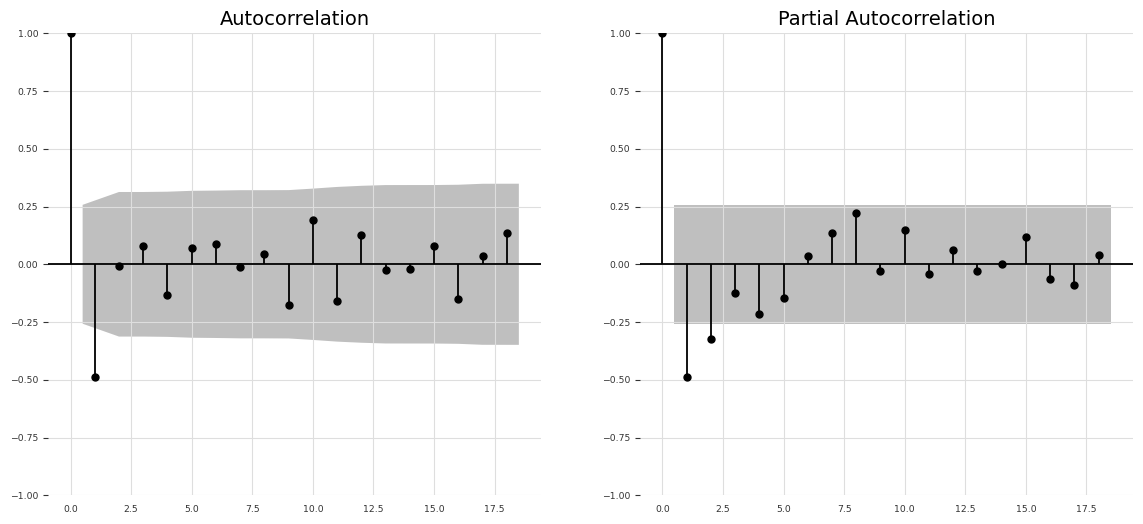

In [53]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1])
plt.show()

In [54]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

24

In [55]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Fri, 21 Mar 2025   AIC                             52.321
Time:                        09:35:44   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
(acorr_ljungbox(results.resid,                              # Applies the Ljung-Box test to the residuals of the model
                lags=25,                                    # Uses 25 lags for autocorrelation testing
                return_df=True) < 0.05)['lb_pvalue'].sum()  # Counts the number of lags where the p-value is below 0.05 (significant autocorrelation)

0

In [57]:
# Perform the Ljung-Box test on residuals to check for autocorrelation
significant_lags = (acorr_ljungbox(results.resid,     # Test residuals for autocorrelation
                                   lags=25,           # Check up to 25 lags
                                   return_df=True) 
                    < 0.05)['lb_pvalue'].sum()        # Count how many p-values are below 0.05 (significant)

# Decision criterion: if too many lags are significant, residuals are not white noise
if significant_lags > 5:                              # Threshold for acceptable number of significant lags
    print("Residuals show autocorrelation — model may be misspecified.")
else:
    print("Residuals resemble white noise — model is likely well specified.")

Residuals resemble white noise — model is likely well specified.


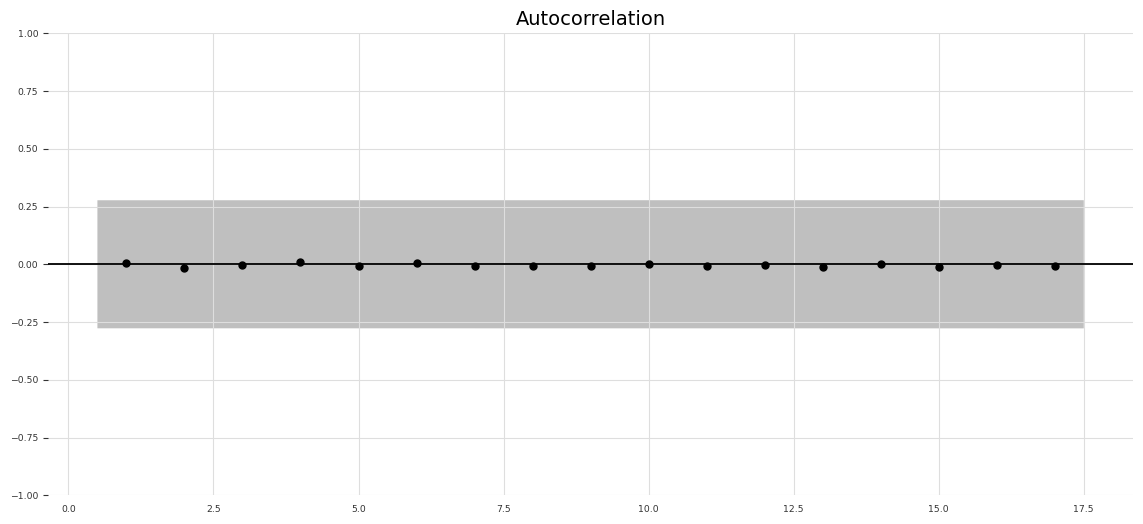

In [58]:
plot_acf(results.resid, zero=False);plt.show()

In [59]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

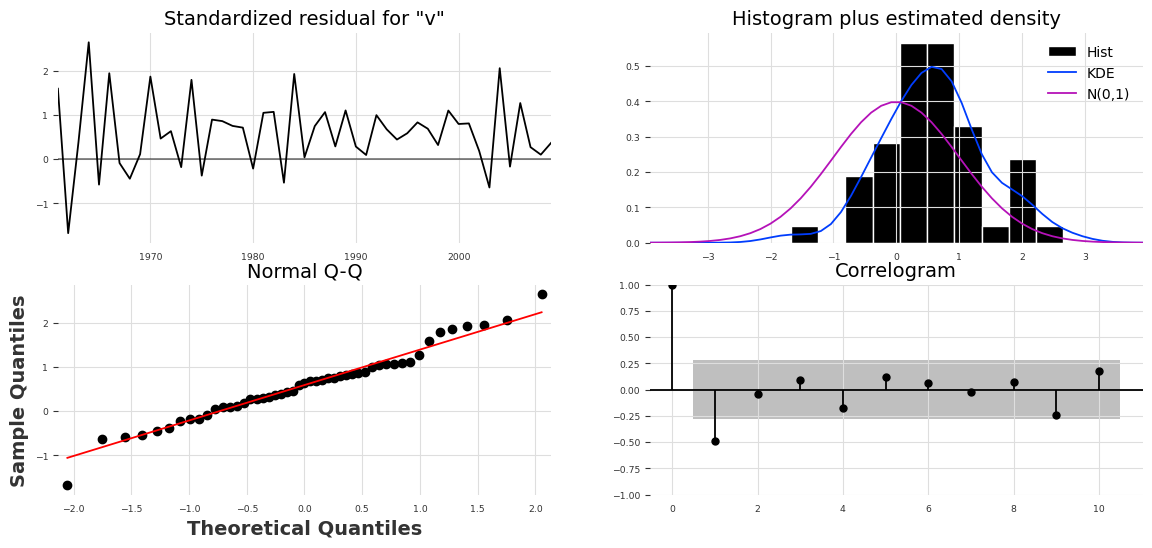

In [60]:
results.plot_diagnostics()
plt.show()

In [61]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [62]:
from scipy.stats import shapiro

# Tests residuals for normality using the Shapiro-Wilk test; returns True if p-value < 0.05 (i.e., residuals are not normally distributed)
shapiro(results.resid)[1] < 0.05  

True

In [63]:
# Perform the Shapiro-Wilk test for normality on the residuals
p_value = shapiro(results.resid)[1]             # Extract the p-value from the test

# Decision criterion: if p-value < 0.05, residuals deviate significantly from normality
if p_value < 0.05:                              # Threshold for rejecting normality
    print("Residuals are not normally distributed — model assumptions may be violated.")
else:
    print("Residuals are normally distributed — normality assumption holds.")

Residuals are not normally distributed — model assumptions may be violated.


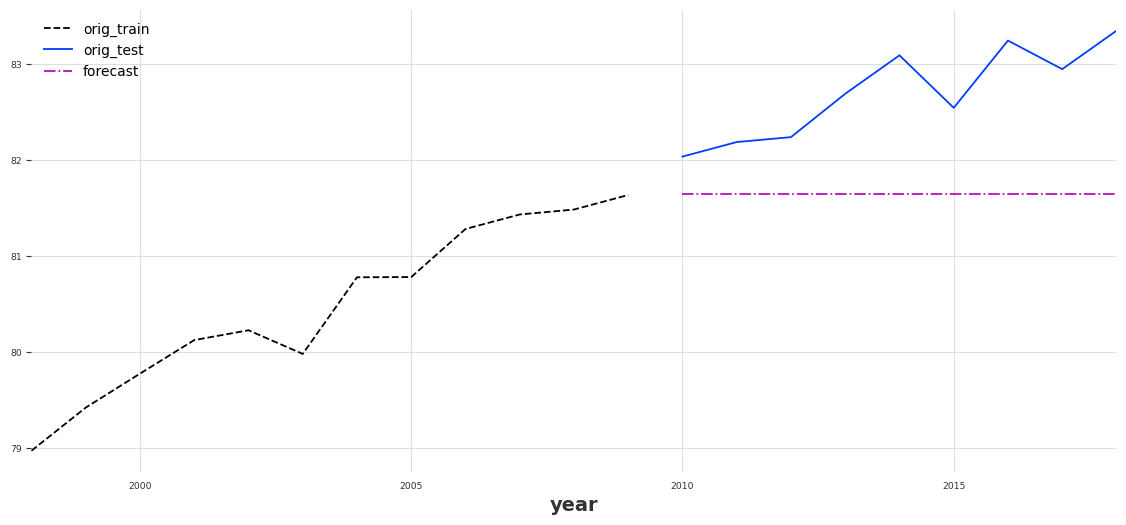

In [64]:
plot_forecast(results, '1998', life_train, life_test);

## Parameters Selection

In [65]:
pv, dv, qv = [list(range(3))]*3             # Define grid search ranges for ARIMA parameters p, d, q (each from 0 to 2)

vals = combinator([pv, dv, qv])             # Generate all possible combinations of (p,d,q) using a custom combinator function

score = {}                                  # Initialize dictionary to store evaluation metrics for each model

for i, (p, d, q) in enumerate(vals):        # Iterate over all (p,d,q) combinations
    m = ARIMA(life_train, order=(p,d,q))    # Create an ARIMA model with current parameters
    res = m.fit()                           # Fit the model to the training data
    y = life_test.values.ravel()            # Flatten the actual test values into a 1D array
    y_hat = res.forecast(steps=len(y))      # Forecast the next values for the length of the test set
    
    score[i] = {                            # Store results in the dictionary
        'order': (p,d,q),                   # ARIMA order
        'AIC': res.aic,                     # Akaike Information Criterion
        'BIC': res.bic,                     # Bayesian Information Criterion
        'AICc': res.aicc,                   # Corrected AIC
        'RMSPE': rmspe(y, y_hat),           # Root Mean Squared Percentage Error
        'RMSE': rmse(y, y_hat),             # Root Mean Squared Error
        'MAPE': mape(y, y_hat),             # Mean Absolute Percentage Error
        'model': res                        # Fitted model object
    }

In [66]:
get_best_model(score, 'AIC');

Best model: 8 with lowest AIC score: 7.698477131195528


In [67]:
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.698477131195528


In [68]:
score[8]

{'order': (0, 2, 2),
 'AIC': 7.698477131195528,
 'BIC': 13.312080163919202,
 'AICc': 8.243931676650073,
 'RMSPE': 0.05593317584020921,
 'RMSE': 0.4633900097823148,
 'MAPE': 0.004491911001968695,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x210be3d1b50>}

In [69]:
score[4]['model'].model_orders

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 1,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [70]:
# Convert the score dictionary to a DataFrame, transpose it, sort by AIC (ascending), and reset the index
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()  

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698477,13.31208,8.243932,0.055933,0.46339,0.004492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.5332,17.100481,10.442291,0.054759,0.453646,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.675876,17.16068,10.606109,0.055732,0.461724,0.00447,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.509602,20.968704,12.904951,0.054477,0.451304,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.94868,23.304685,15.377251,0.072917,0.604417,0.006082,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.674292,27.159096,20.604524,0.054421,0.451284,0.003984,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.195622,28.809225,23.741077,0.048487,0.402034,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.291578,32.85886,26.200669,0.046799,0.388013,0.003499,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.315044,35.057446,31.581711,0.047363,0.392699,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.426614,39.102074,33.959947,0.043396,0.359744,0.00338,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [71]:
# Convert the score dictionary to a DataFrame, transpose it, sort by BIC (ascending), and reset the index
pd.DataFrame(score).T.sort_values(by='BIC').reset_index()  

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698477,13.31208,8.243932,0.055933,0.46339,0.004492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.5332,17.100481,10.442291,0.054759,0.453646,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.675876,17.16068,10.606109,0.055732,0.461724,0.00447,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.509602,20.968704,12.904951,0.054477,0.451304,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.94868,23.304685,15.377251,0.072917,0.604417,0.006082,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.674292,27.159096,20.604524,0.054421,0.451284,0.003984,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.195622,28.809225,23.741077,0.048487,0.402034,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.291578,32.85886,26.200669,0.046799,0.388013,0.003499,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.315044,35.057446,31.581711,0.047363,0.392699,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.426614,39.102074,33.959947,0.043396,0.359744,0.00338,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [72]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Fri, 21 Mar 2025   AIC                              7.698
Time:                        09:35:46   BIC                             13.312
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9475     20.438     -0.095      0.924     -42.005      38.110
ma.L2          0.9994     20.970      0.048      0.962     -40.101      42.100
sigma2         0.0497      1.044      0.048      0.962      -1.996       2.096
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

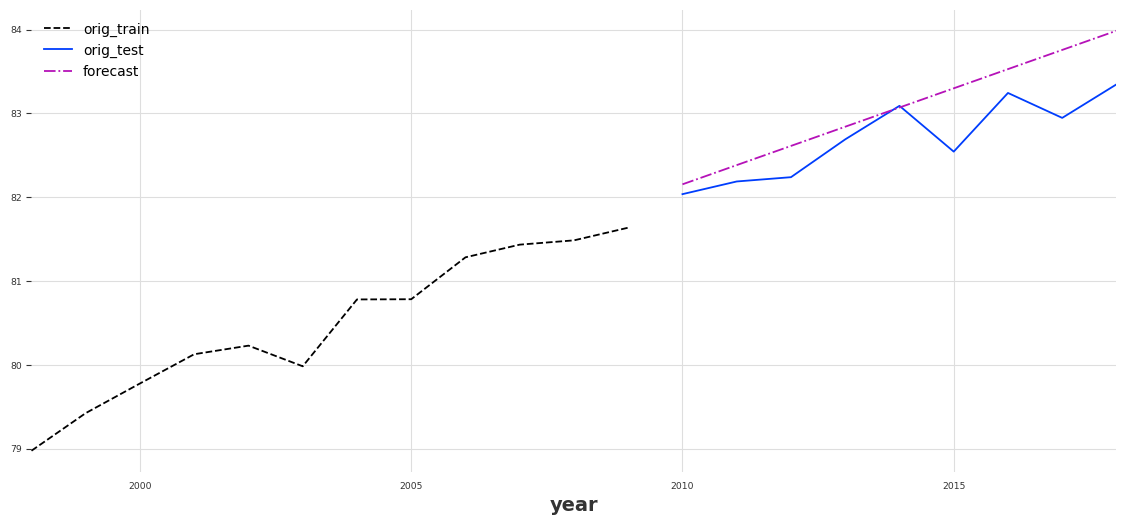

In [73]:
plot_forecast(best_m, '1998', life_train, life_test);

# Recipe 4. Forecasting Univariate Time Series Data with Seasonal ARIMA

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = [14, 4]  

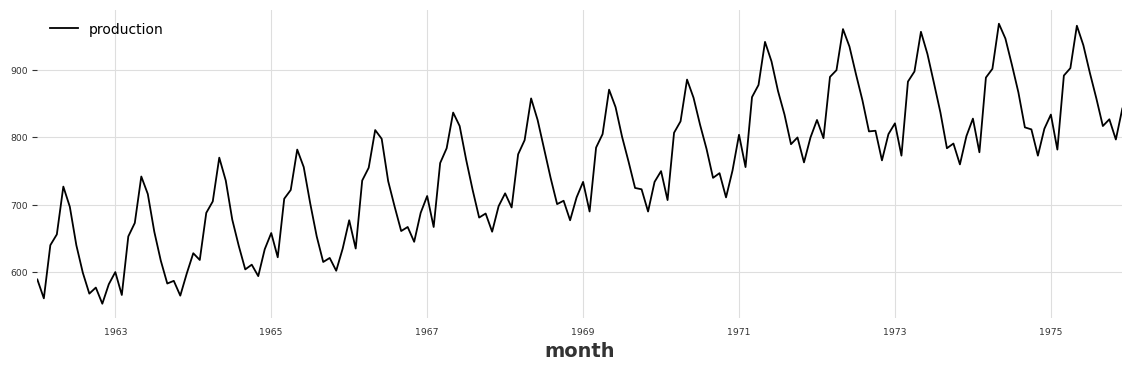

In [75]:
milk.plot();

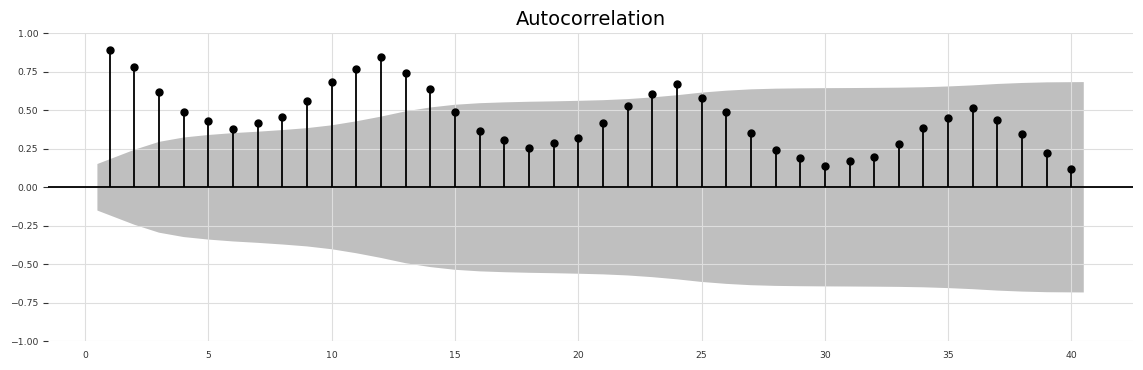

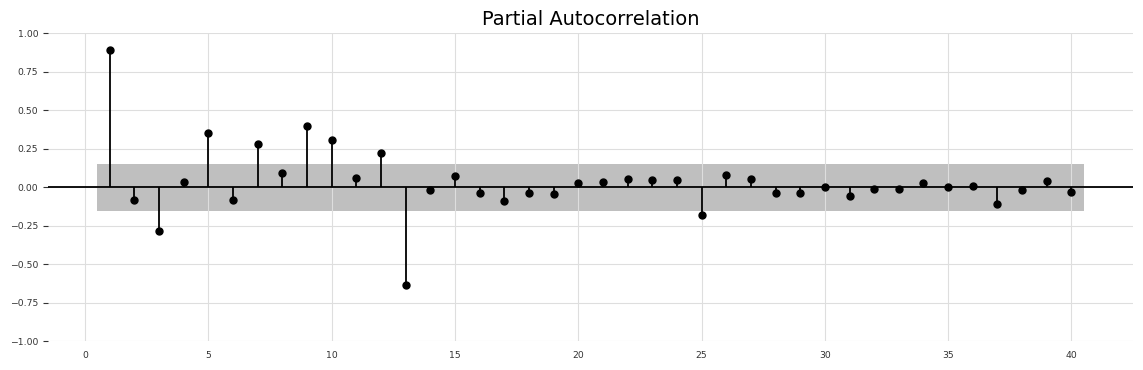

In [76]:
plot_acf(milk, lags=40, zero=False)   # Plots the autocorrelation function (ACF) of the milk series up to 40 lags, excluding lag 0

plot_pacf(milk, lags=40, zero=False)  # Plots the partial autocorrelation function (PACF) of the milk series up to 40 lags, excluding lag 0

plt.show()                            # Displays both ACF and PACF plots

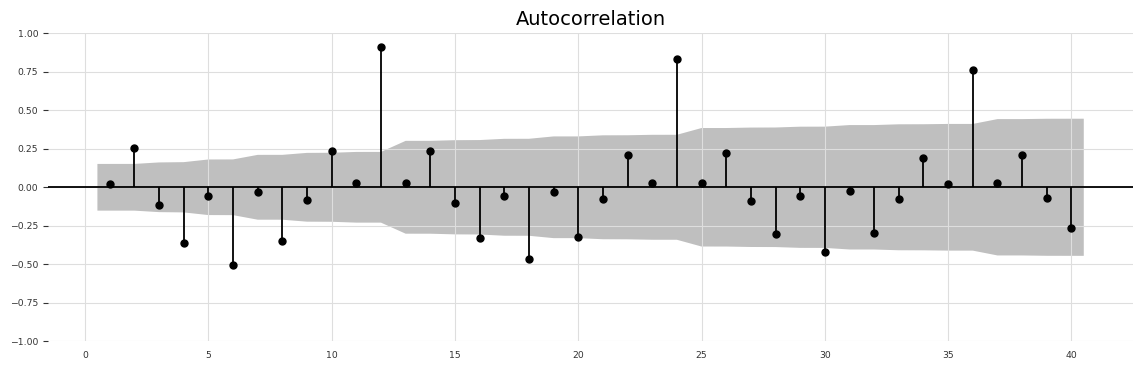

In [77]:
# Plots the ACF of the milk series after first differencing, removing NaNs, up to 40 lags (excluding lag 0)
plot_acf(milk.diff(1).dropna(), lags=40, zero=False)  

# Displays the ACF plot
plt.show()                                            

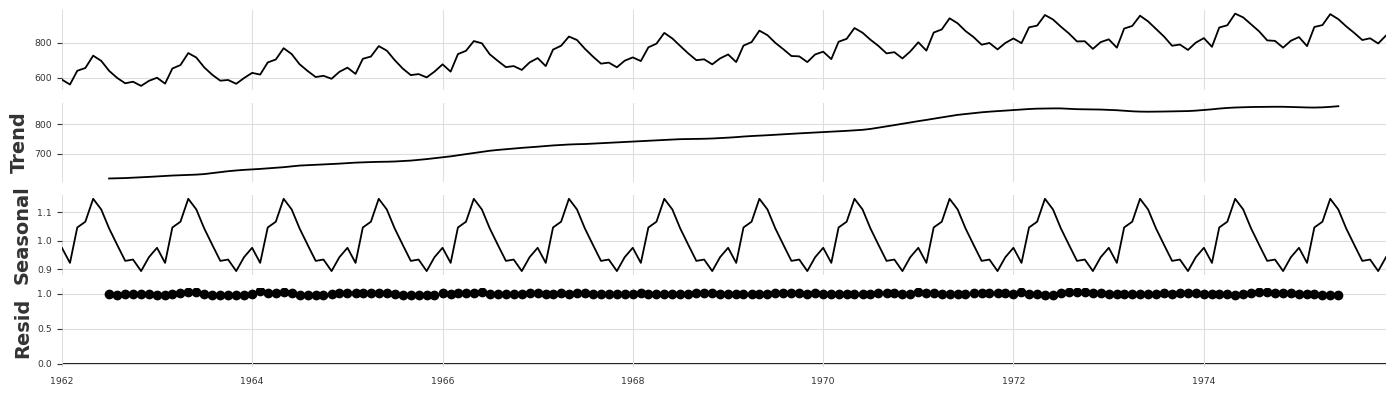

In [78]:
# Decomposes the milk time series into trend, seasonal, and residual components using a multiplicative model with yearly seasonality (12 months)
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')  

# Plots the decomposed components
decomposed.plot()                                                         

# Displays the decomposition plot
plt.show()                                                                

In [79]:
# Extracts the seasonal component from the decomposed time series and stores it in 'milk_s'
milk_s = decomposed.seasonal

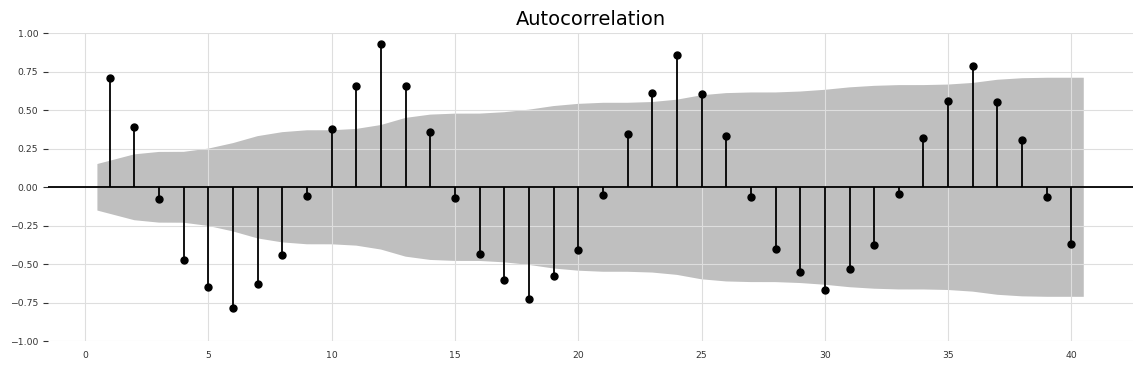

In [80]:
# Plots the autocorrelation function (ACF) of the seasonal component up to 40 lags, excluding lag 0
plot_acf(milk_s, zero=False, lags=40)  

# Displays the ACF plot
plt.show()                             

In [81]:
# Applies seasonal differencing with a lag of 12 (to remove yearly seasonality) and drops resulting NaN values
milk_dif_12 = milk.diff(12).dropna()            

# Applies seasonal differencing (lag 12), then first differencing (lag 1) to remove trend, and drops NaN values
milk_dif_12_1 = milk.diff(12).diff(1).dropna()  

Original:
'Non-Stationary	 p-value:0.6274267086030308 	 lags:13

Deseasonalize:
'Non-Stationary	 p-value:0.1607988052771142 	 lags:12

Deseasonalize and Detrend:
'Stationary	 p-value:1.865423431878921e-05 	 lags:11




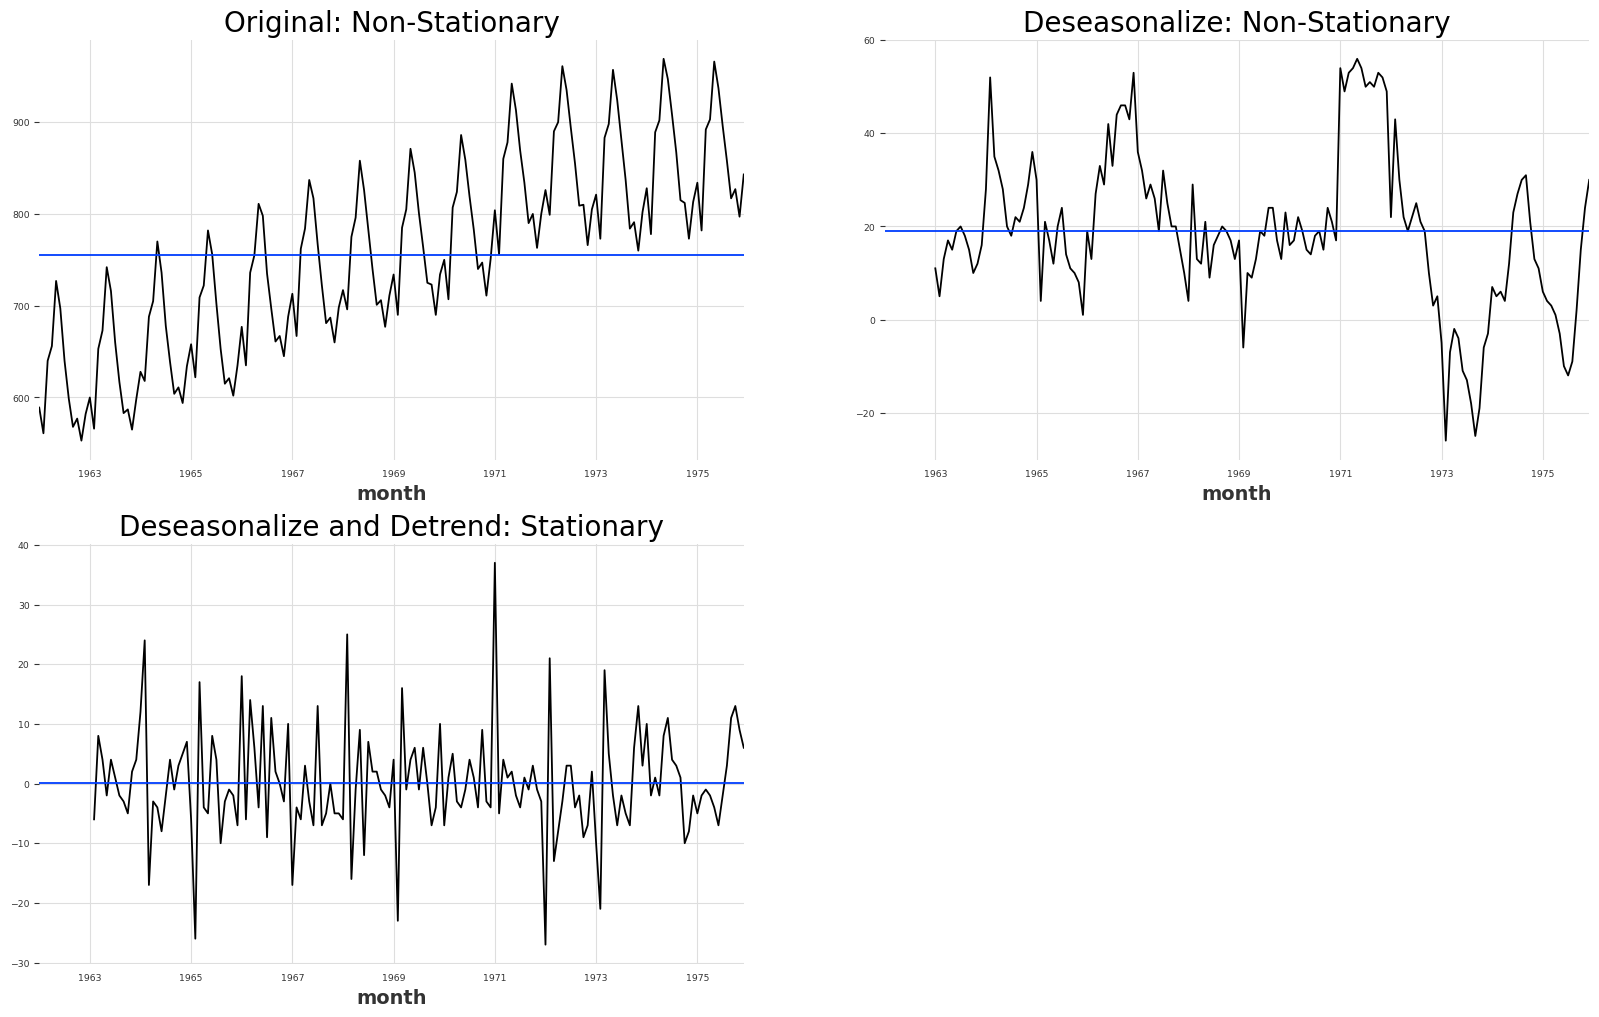

In [82]:
sets = [milk, milk_dif_12, milk_dif_12_1]                # List of time series: original, seasonally differenced, and seasonally + first differenced
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']  # Corresponding descriptions for plot titles

fig, ax = plt.subplots(2, 2, figsize=(20, 12))           # Create a 2x2 grid of subplots with specified figure size
index, l = milk.index, milk.shape[0]                     # Store the original index and number of observations

for i, (d_set, d_desc) in enumerate(zip(sets, desc)):    # Loop over each dataset and its description
    v, r = i // 2, i % 2                                 # Determine row (v) and column (r) position in subplot grid
    print(f'{d_desc}:')##################
    print('='*56)
    outcome, pval = check_stationarity(d_set)            # Perform stationarity check on the dataset (e.g., ADF test)
    print()##############################
    d_set.plot(ax=ax[v, r], title=f'{d_desc}: {outcome}', legend=False)         # Plot the dataset with title indicating stationarity result
    pd.Series(d_set.mean().values.tolist() * l, index=index).plot(ax=ax[v, r])  # Plot the mean line for reference
    ax[v, r].title.set_size(20)                          # Set title font size
    
print()                       # Separate tests from graphs

ax[1, 1].set_visible(False)   # Hide the unused subplot (bottom-right corner)

plt.show()                    # Display all plots

### How to Determine AR and MA terms

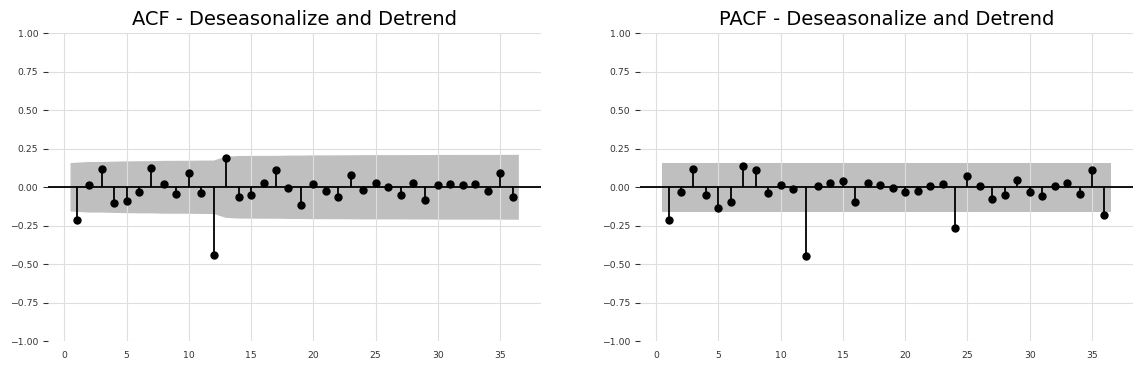

In [83]:
fig, ax = plt.subplots(1, 2)  # Create a figure with 1 row and 2 columns of subplots

# Plot the autocorrelation (ACF) of the differenced series on the left subplot
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')  

# Plot the partial autocorrelation (PACF) of the differenced series on the right subplot
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}') 

plt.show()                   # Display both ACF and PACF plots

Lags: [1, 12, 24, 36, 48]


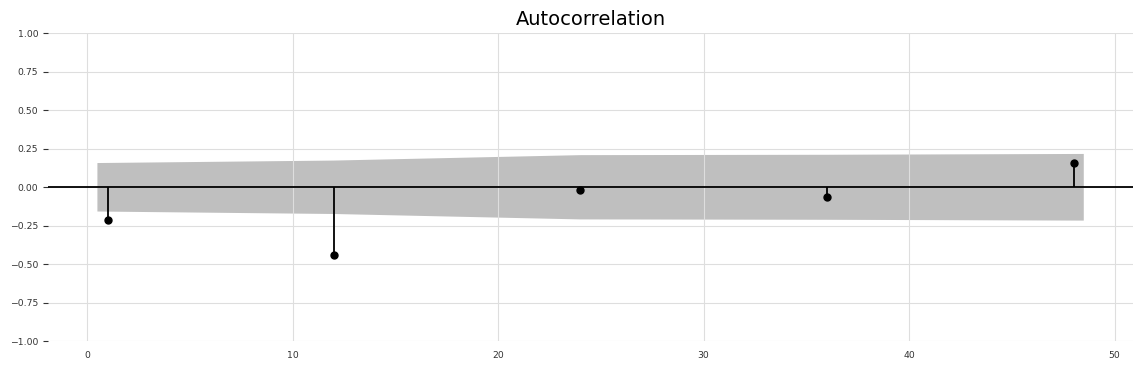

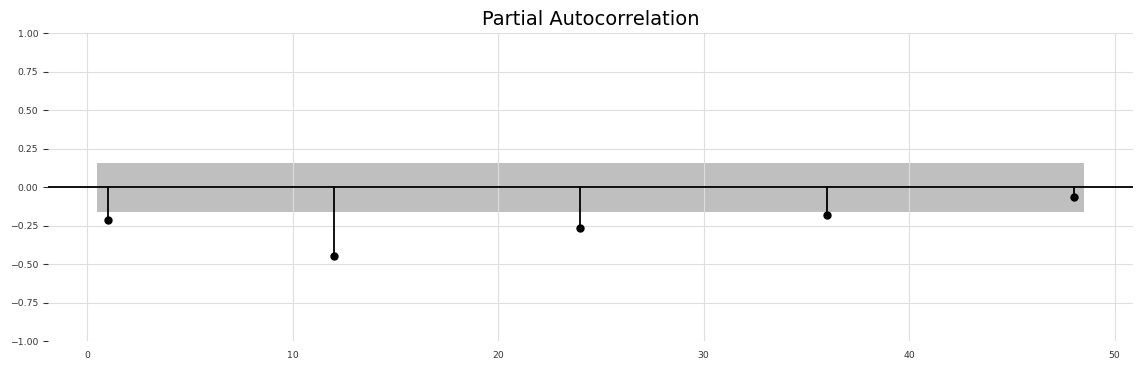

In [84]:
lags = [i for i in range(12, 60, 12)]  # Create a list of seasonal lags: [12, 24, 36, 48]
lags.insert(0, 1)                      # Insert lag 1 at the beginning for short-term autocorrelation: [1, 12, 24, 36, 48]
print("Lags:",lags)                    # Output the list of selected lags

# Plot ACF using the custom list of lags on seasonally and trend-differenced data
plot_acf(milk.diff(12).diff(1).dropna(), zero=False, lags=lags)   

# Plot PACF using the same custom lags
plot_pacf(milk.diff(12).diff(1).dropna(), zero=False, lags=lags);  

### Fitting a SARIMA Model

In [85]:
sarima_model = SARIMAX(milk_train,                        # Define the SARIMA model using the training data
                       order=(0,1,1),                     # Set non-seasonal order: (p=0, d=1, q=1)
                       seasonal_order=(0,1,1,12))         # Set seasonal order: (P=0, D=1, Q=1, s=12 for yearly seasonality)

model = sarima_model.fit(disp=0)                          # Fit the model without displaying optimization output (disp=0)

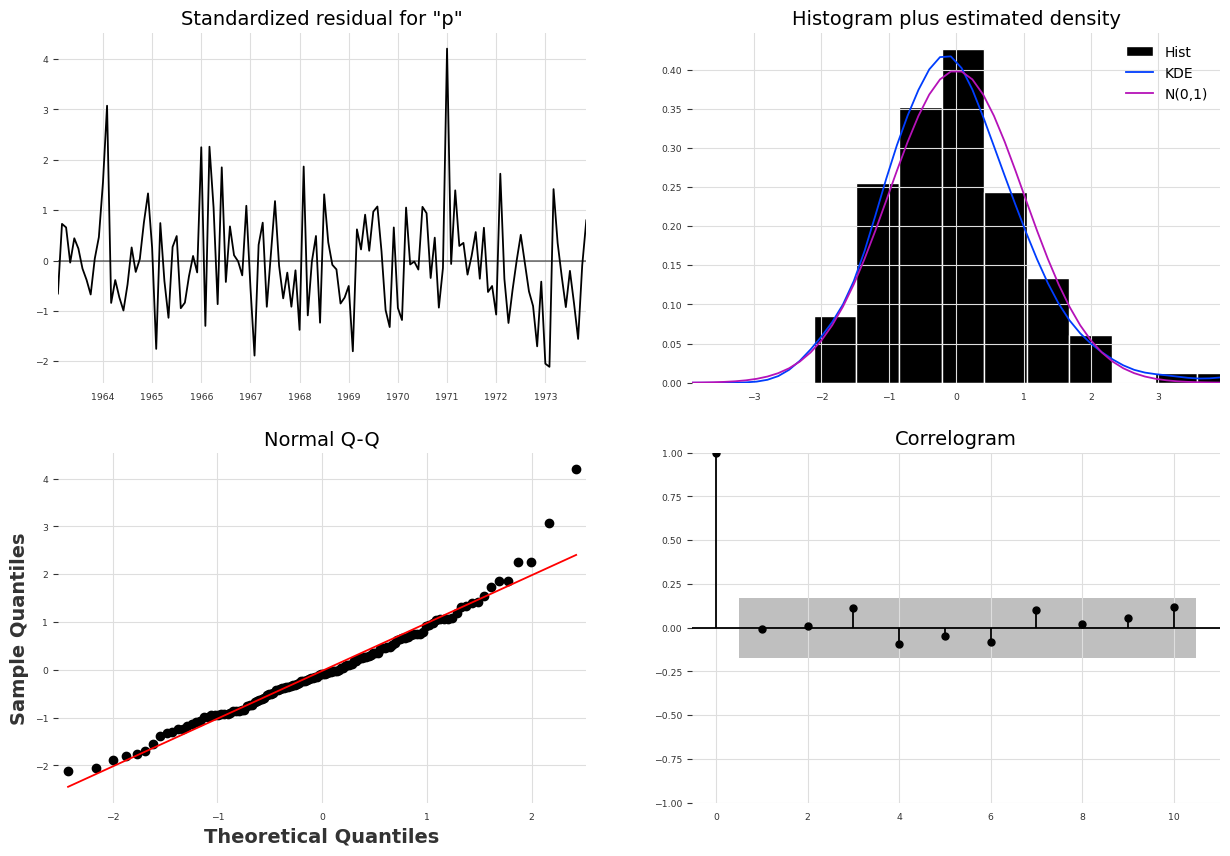

In [86]:
# Plots diagnostic checks for the fitted SARIMA model, including standardized residuals, histogram + KDE, Q-Q plot, and correlogram
model.plot_diagnostics(figsize=(15,10))

plt.show()

In [87]:
# Displays a detailed statistical summary
model.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Fri, 21 Mar 2025   AIC                            903.335
Time:                                    09:35:48   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.801
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

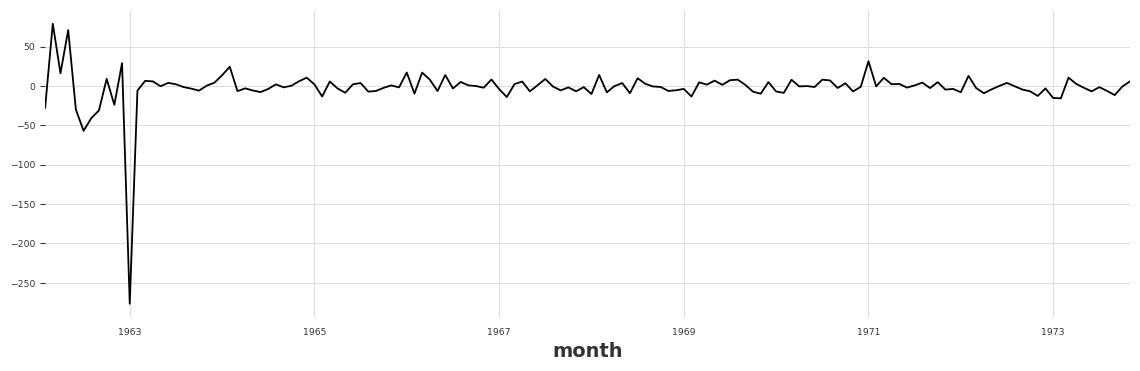

In [88]:
# Plots the residuals of the fitted SARIMA model, excluding the first value (which may be NaN due to differencing)
model.resid[1:].plot();

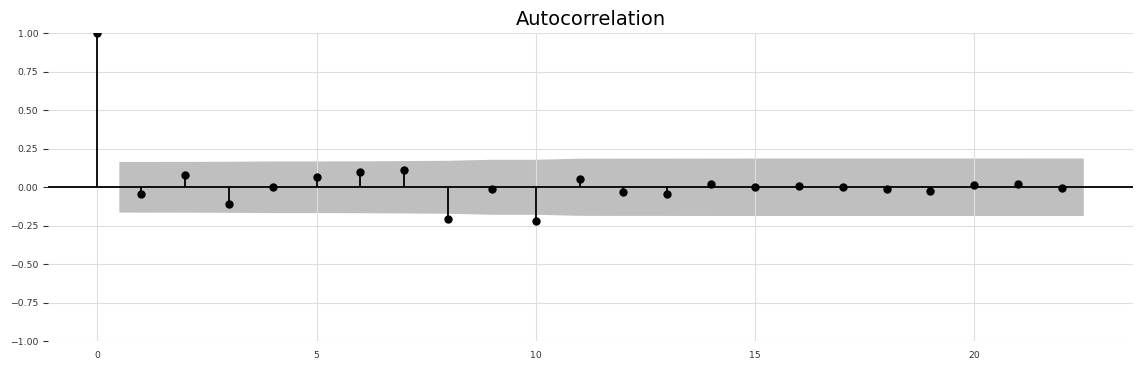

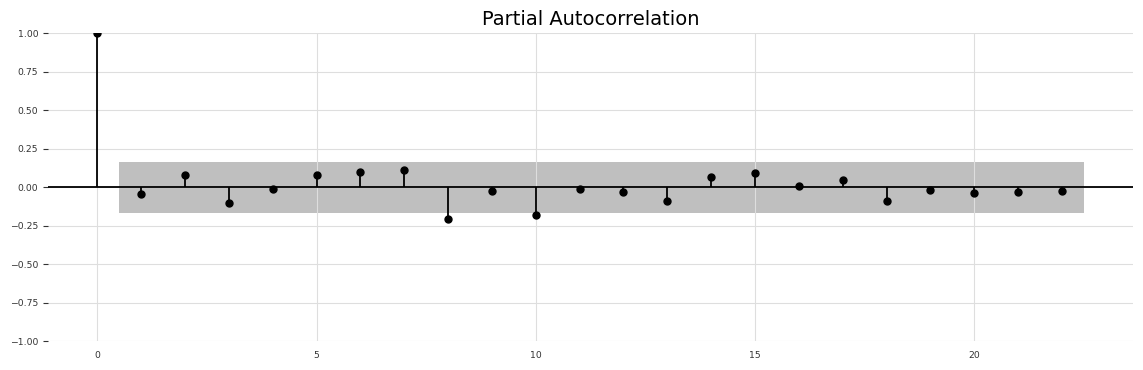

In [89]:
plot_acf(model.resid[1:])    # Plots the autocorrelation function (ACF) of the residuals, skipping the first value
plot_pacf(model.resid[1:])   # Plots the partial autocorrelation function (PACF) of the residuals, skipping the first value
plt.show();                  # Displays both ACF and PACF plots

<Axes: xlabel='month'>

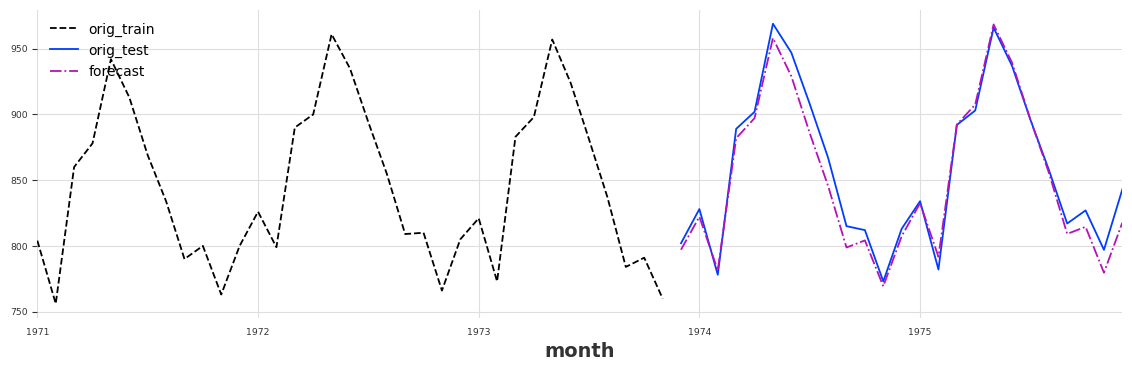

In [90]:
plot_forecast(model, '1971', milk_train, milk_test)

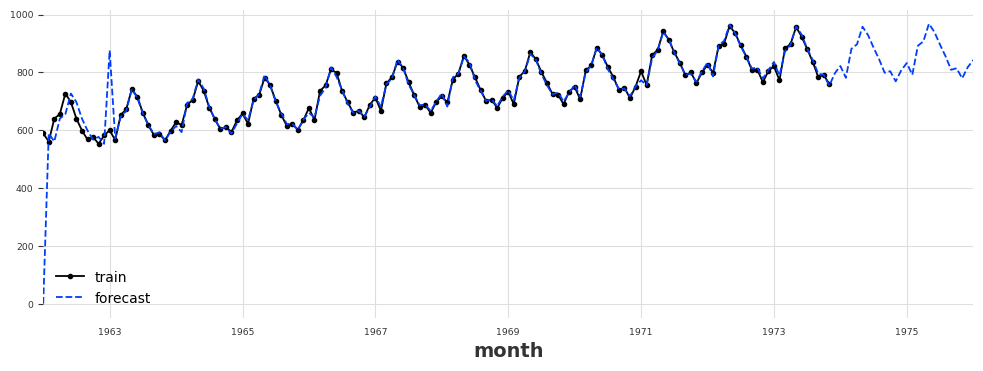

In [91]:
n = milk.shape[0]                            # Get the total number of observations in the original milk dataset

milk_train.plot(style='.-', figsize=(12,4))  # Plot the training data with dot-line style and set the figure size

model.predict(end=n).plot(style='--')        # Plot the model's forecast up to the end of the full dataset using dashed lines

plt.legend(['train', 'forecast']);           # Add a legend to distinguish training data from forecast

## Another SARiMA Model

In [92]:
P_ns, D_ns, Q_ns = [list(range(3))]*3          # Define search ranges for non-seasonal parameters (p, d, q): each from 0 to 2
P_s, D_s, Q_s = [list(range(2))]*3             # Define search ranges for seasonal parameters (P, D, Q): each from 0 to 1

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')

    m = SARIMAX(milk_train,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, 12),  # 12 = seasonal period (monthly data)
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0)                        # Fit the model silently

    y = milk_test.values.ravel()               # Flatten actual test values to 1D
    y_hat = res.forecast(steps=len(y))         # Forecast same number of steps as test set

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'BIC': res.bic,                        # Bayesian Information Criterion
        'RMSPE': rmspe(y, y_hat),              # Root Mean Squared Percentage Error
        'RMSE': rmse(y, y_hat),                # Root Mean Squared Error
        'MAPE': mape(y, y_hat),                # Mean Absolute Percentage Error
        'model': res                           # Fitted model object
    }

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)


In [93]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.4217652843622


In [94]:
# Convert the score dictionary to a DataFrame, transpose it, sort by AIC (ascending), and reset the index
results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 

results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328245,27.797614,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998609,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,191,"(2, 1, 2)","(1, 1, 1)",797.101728,798.148457,816.316252,0.11192,9.610575,0.009032,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289728,24.535473,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,215,"(2, 2, 2)","(1, 1, 1)",797.419174,798.475778,816.572564,0.179478,15.243607,0.014577,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611922,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188641,812.362843,0.133006,11.396142,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427692,36.195046,0.03686,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [95]:
# Convert the score dictionary to a DataFrame, transpose it, sort by BIC (ascending), and reset the index
results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()  

results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328245,27.797614,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.13409,11.489677,0.01037,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289728,24.535473,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611922,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188641,812.362843,0.133006,11.396142,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427692,36.195046,0.03686,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998609,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,131,"(1, 2, 1)","(0, 1, 1)",802.770371,803.134007,813.7501,0.20581,17.449873,0.016939,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [96]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.4217652843622,
 'AICc': 796.2068120133342,
 'BIC': 811.8389559747292,
 'RMSPE': 0.17818990207115598,
 'RMSE': 15.135861916002764,
 'MAPE': 0.014454262783870993,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x210befdfad0>}

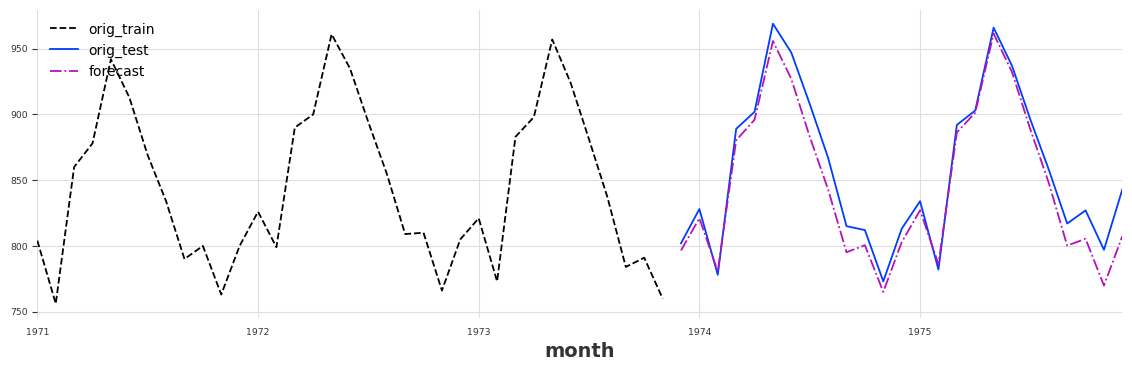

In [97]:
plot_forecast(best_model, '1971', milk_train, milk_test);